# Assignment 3

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import minimize 
from scipy.stats import norm, t
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import minimize 

### Problem 1
Calculate and compare the expected value and standard deviation of price at time t(𝑃𝑡) , given
each of the 3 types of price returns, assuming 𝑟𝑡∼𝑁(0,σ2).  Simulate each return equation using 𝑟𝑡∼𝑁(0,σ2)and show the mean and standard deviation match your expectations.


In [503]:

sigma = 0.25
price_pre = 100
n = 100000
ran = np.random.normal(0, sigma, 100000)
# Classic Brownian Motion 
# E[pt] = E[p0]
# where p0 is the initial value of the process. In other words, the expected value of classical Brownian motion is simply its starting value.
price_brownian = ran + price_pre 
# Arithmetic Return System
price_arithmetic = price_pre * (1 + ran)
# Log Return or Geometric 
price_log = price_pre * np.exp(ran)

print("mean of brownian: {:.5f}" .format(np.mean(price_brownian)), "std of brownian: {:.3f}" .format(np.std(price_brownian)))
print("Theoretical mean of brownian: {:.5f}" .format(price_pre), "Theoretical std of brownian: {:.3f}" .format(sigma))
print("mean of Arithmetic Return: {:.5f}" .format(np.mean(price_arithmetic)), "std of Arithmetic Return: {:.3f}" .format(np.std(price_arithmetic)))
print("Theoretical mean of Arithmetic Return: {:.5f}" .format(price_pre), "Theoretical std of Arithmetic Return: {:.3f}" .format(sigma*price_pre))
print("mean of log return : {:.5f}" .format(np.mean(price_log)), "std of log return: {:.3f}" .format(np.std(price_log)))
print("Theoretical mean of log return: {:.5f}" .format(price_pre* np.exp(0.5*sigma**2)), "Theoretical std of log return: {:.3f}" .format(np.sqrt((np.exp(sigma**2)-1)*np.exp(2*(np.log(price_pre))+sigma**2))))

mean of brownian: 99.99973 std of brownian: 0.249
Theoretical mean of brownian: 100.00000 Theoretical std of brownian: 0.250
mean of Arithmetic Return: 99.97321 std of Arithmetic Return: 24.936
Theoretical mean of Arithmetic Return: 100.00000 Theoretical std of Arithmetic Return: 25.000
mean of log return : 103.12950 std of log return: 26.109
Theoretical mean of log return: 103.17434 Theoretical std of log return: 26.202


Text(0.5, 1.0, 'Log Return or Geometric')

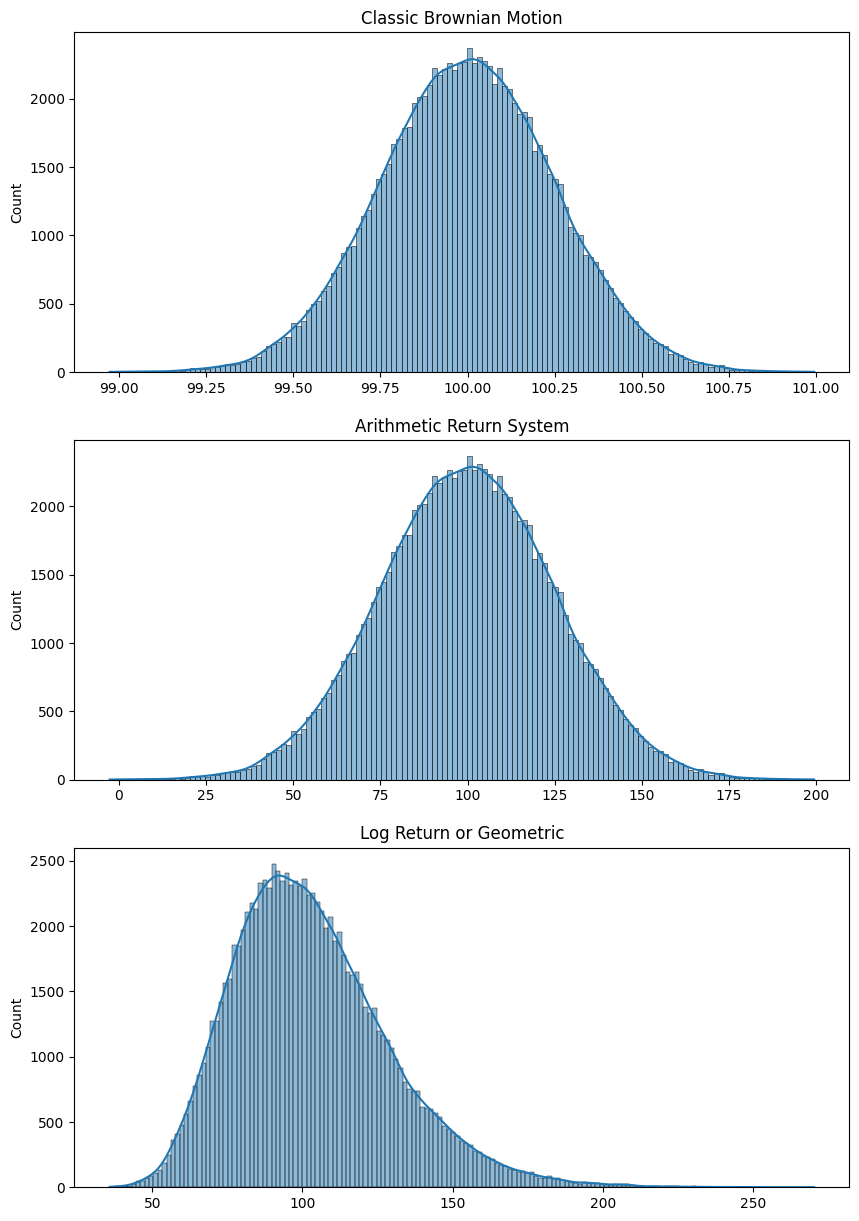

In [55]:
# plot


fig, axes = plt.subplots(3, 1, figsize=(10, 15))

sns.histplot(price_brownian, ax=axes[0], kde=True)
sns.histplot(price_arithmetic, ax=axes[1], kde=True)
sns.histplot(price_log, ax=axes[2], kde=True)

axes[0].set_title("Classic Brownian Motion")
axes[1].set_title("Arithmetic Return System")
axes[2].set_title("Log Return or Geometric")


### Problem 2
Implement a function similar to the “return_calculate()” in this week’s code.  Allow the user to
specify the method of return calculation.
Use DailyPrices.csv.  Calculate the arithmetic returns for all prices.
Break the returns for META into 2 groups, a modeling group and a holdout sample.  Make the
holdout sample be the last 60 observations.
Remove the mean from the series so that the mean(META)=0
Calculate VaR
1. Using a normal distribution.
2. Using a normal distribution with an Exponentially Weighted variance ( )λ=0.94
3. Using a MLE fitted T distribution.
4. Using a fitted AR(1) model.
5. Using a Historic Simulation.

Compare the 5 values.


In [3]:
# specify the method of return calculation
def return_calculate(prices, method = 'Arithmetic'):
    prices_date = prices.Date[1:]
    row = len(prices_date)

    col = prices.columns
    col_new = col.drop('Date')
    le = len(col_new)

    price_new = prices[col_new].to_numpy()

    price_return = np.empty((row,le))

    for i in range(row):
        for j in range(le):
            price_return[i][j] = price_new[i+1][j]/price_new[i][j]


    if method == 'Arithmetic':
        price_return = price_return - 1.0
    elif method == 'Log':
        price_return = np.log(price_return)
    else:
        raise ValueError(f'Wrong method')

    dateColumn = "Date"
    prices_da = pd.DataFrame({dateColumn: prices_date}) 

    for i in range(le):
        prices_da[col_new[i]] = price_return[:,i]
    
    return prices_da

In [5]:
# Calculate the arithmetic returns for all prices
prices = pd.read_csv('DailyPrices.csv')
return_calculate(prices)


,Date,SPY,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,META,NVDA,...,PNC,MDLZ,MO,ADI,GILD,LMT,SYK,GM,TFC,TJX
1,2/15/2022 0:00,0.016127,0.023152,0.018542,0.008658,0.053291,0.007987,0.008319,0.015158,0.091812,...,0.012807,-0.004082,0.004592,0.052344,0.003600,-0.012275,0.033021,0.026240,0.028572,0.013237
2,2/16/2022 0:00,0.001121,-0.001389,-0.001167,0.010159,0.001041,0.008268,0.007784,-0.020181,0.000604,...,0.006757,-0.002429,0.005763,0.038879,0.009294,0.012244,0.003363,0.015301,-0.001389,-0.025984
3,2/17/2022 0:00,-0.021361,-0.021269,-0.029282,-0.021809,-0.050943,-0.037746,-0.037669,-0.040778,-0.075591,...,-0.034949,0.005326,0.015017,-0.046988,-0.009855,0.004833,-0.030857,-0.031925,-0.033380,-0.028763
4,2/18/2022 0:00,-0.006475,-0.009356,-0.009631,-0.013262,-0.022103,-0.016116,-0.013914,-0.007462,-0.035296,...,-0.000646,-0.000908,0.007203,-0.000436,-0.003916,-0.005942,-0.013674,-0.004506,-0.003677,0.015038
5,2/22/2022 0:00,-0.010732,-0.017812,-0.000729,-0.015753,-0.041366,-0.004521,-0.008163,-0.019790,-0.010659,...,0.009494,0.007121,-0.008891,0.003243,-0.001147,-0.000673,0.008342,-0.037654,-0.002246,-0.013605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2/3/2023 0:00,-0.010629,0.024400,-0.023621,-0.084315,0.009083,-0.027474,-0.032904,-0.011866,-0.028053,...,-0.004694,-0.011251,-0.001277,-0.002677,0.038211,0.004134,0.002336,-0.008916,-0.005954,0.001617
245,2/6/2023 0:00,-0.006111,-0.017929,-0.006116,-0.011703,0.025161,-0.017942,-0.016632,-0.002520,-0.000521,...,-0.014451,0.003945,0.001066,-0.007102,0.022012,0.021826,-0.041181,0.005106,-0.009782,-0.004595
246,2/7/2023 0:00,0.013079,0.019245,0.042022,-0.000685,0.010526,0.046064,0.044167,0.029883,0.051401,...,-0.000368,-0.016473,-0.008518,0.019544,-0.003590,-0.001641,0.003573,0.001451,0.008669,-0.003618
247,2/8/2023 0:00,-0.010935,-0.017653,-0.003102,-0.020174,0.022763,-0.076830,-0.074417,-0.042741,0.001443,...,-0.008469,-0.004456,-0.001289,-0.018009,-0.004416,0.002819,-0.015526,0.004106,-0.015391,0.009363


In [6]:
return_all_prices = return_calculate(prices)
META = return_all_prices['META']
print(META)

1      0.015158
2     -0.020181
3     -0.040778
4     -0.007462
5     -0.019790
         ...   
244   -0.011866
245   -0.002520
246    0.029883
247   -0.042741
248   -0.030039
Name: META, Length: 248, dtype: float64


In [7]:
# Remove the mean from the series so that the mean(META)=0

META_mean = META.mean()
META_zero = META - META_mean



In [8]:
def var_quantile(mean_data,data, alpha=0.05):
    return mean_data-np.quantile(data,alpha)



In [9]:
# Using a normal distribution
def var_normal_distribution(meta,size=10000):
    sigma = meta.std()
    mean_data=meta.mean()
    simu_norm = np.random.normal(mean_data,sigma,size)
    var_normal = var_quantile(mean_data,simu_norm)
    return simu_norm, var_normal


var_normal_distribution(META_zero)
    

(array([-0.08234128, -0.05348842,  0.07009727, ...,  0.00034494,
        -0.01208275, -0.08202254]),
 0.06535410999221455)

In [10]:
# calculate weight covariance
def preprocess_returns(returns):

    returns_array = returns.values
    mean_return = np.mean(returns_array, axis=0)
    normalized_returns = returns_array - mean_return
    return normalized_returns, mean_return


def exp_weighted_cov(returns, lambda_=0.94):
    
    normalized_returns, mean_return = preprocess_returns(returns)
    n = len(returns)
    weighted_cov = np.cov(normalized_returns.T)
    for t in range(1, n):
        current_return = normalized_returns[t]
        weighted_cov = lambda_ * weighted_cov + (1 - lambda_) * np.outer(current_return, current_return)
    return weighted_cov


exp_weighted_cov(META_zero)
#print(type(META_zero))

array([[0.00308672]])

In [11]:
# Using a normal distribution with an Exponentially Weighted variance ( )λ=0.94
def var_normal_weighted(meta ,size=10000):
    mean_data=meta.mean()
    sigma = np.sqrt(exp_weighted_cov(META_zero))
    sigma=sigma[0][0]
    simu_norm = np.random.normal(mean_data,sigma,size)
    var_normal = var_quantile(mean_data,simu_norm)
    return simu_norm, var_normal

var_normal_weighted(META_zero)    

(array([ 0.0714704 , -0.05868345,  0.12769985, ..., -0.02361611,
        -0.01566043,  0.05136593]),
 0.09066213454322505)

In [12]:
# MLE fitted T distribution
def var_t_MLE(returns, size=10000):
    df, loc, scale = t.fit(returns)
    
    sim_returns = t.rvs(df, loc=loc, scale=scale, size=size)
    mean=0
    # Calculate VaR at specified confidence level
    var_t = var_quantile(mean,sim_returns)
    
    return  sim_returns,var_t
var_t_MLE(META_zero)

(array([-0.02904626, -0.01524175, -0.02385451, ..., -0.02375836,
         0.02484796,  0.01738208]),
 0.055877272443066645)

In [13]:
# Using a fitted AR(1) model
def var_ar1(returns, size=10000):

    model = ARIMA(returns, order=(1, 0, 0)).fit()
    alp = model.params[0]
    resid = model.resid
    sigma = np.std(resid)
    return_sim = np.empty(size)
    return_ls= returns.iloc[-1]
    simulated_returns = alp * return_ls + sigma * np.random.normal(size=size)
    mean= returns.mean()
    ar1 = var_quantile(mean,simulated_returns)
    return return_sim,ar1

var_ar1(META_zero)

(array([-0.26836922, -0.12722455, -0.10894257, ...,  0.02357964,
         0.02484796,  0.35655125]),
 0.06491034482953557)

In [14]:
# Using a Historic Simulation
def var_historic(meta):
    mean_data=meta.mean()
    var_his= var_quantile(mean_data,meta)
    
    return meta,var_his
var_historic(META_zero)

(1      0.015175
 2     -0.020165
 3     -0.040761
 4     -0.007446
 5     -0.019774
          ...   
 244   -0.011850
 245   -0.002503
 246    0.029899
 247   -0.042725
 248   -0.030022
 Name: META, Length: 248, dtype: float64,
 0.0546200790823787)

In [15]:
def plot_var(series, var, title):
    series_clean = np.nan_to_num(series, nan=np.nanmean(series))
    sns.histplot(series_clean, bins=80, kde=True)
    plt.axvline(-var,  linestyle='--')
    plt.title(title + ' = {:.6f}'.format(var))
    plt.show()
    #print('$VaR {} = {:.6f}'.format(title,(var-META.mean()) * prices['META'].values[-1]))

In [16]:
simu_norm, var_norm=var_normal_distribution(META_zero)
print(simu_norm,var_norm)

[-0.02222113  0.0781381  -0.03710703 ... -0.02522383  0.00290288
  0.03523973] 0.06425861848179272


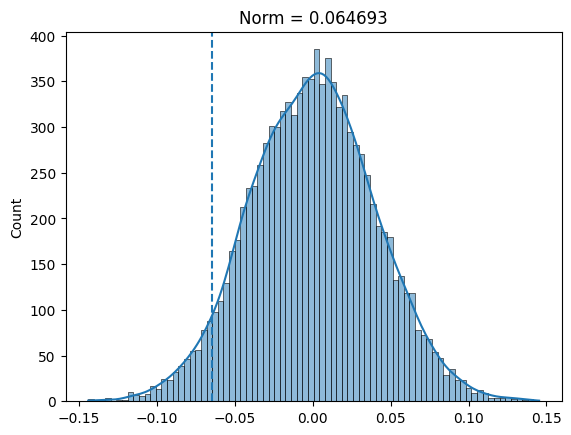

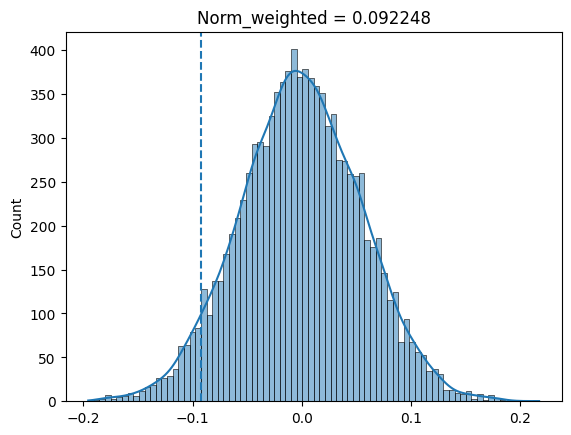

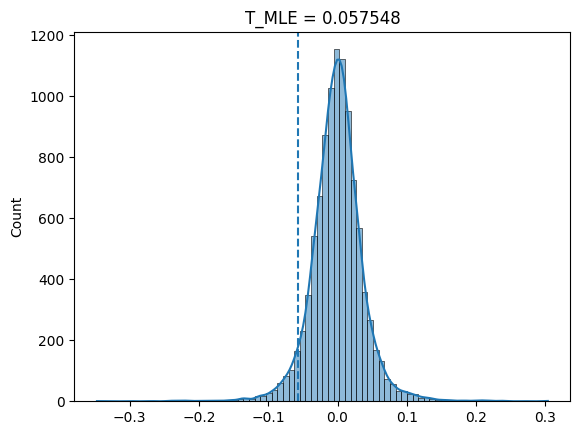

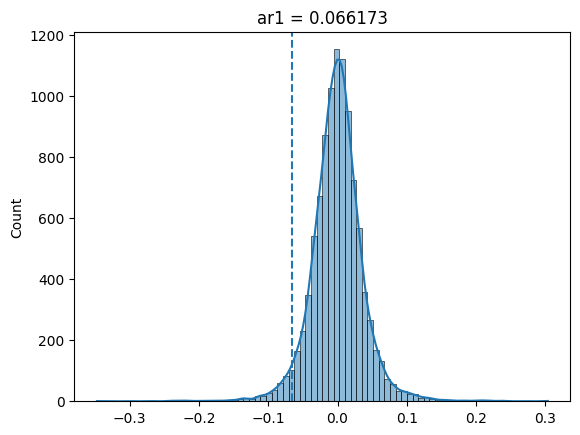

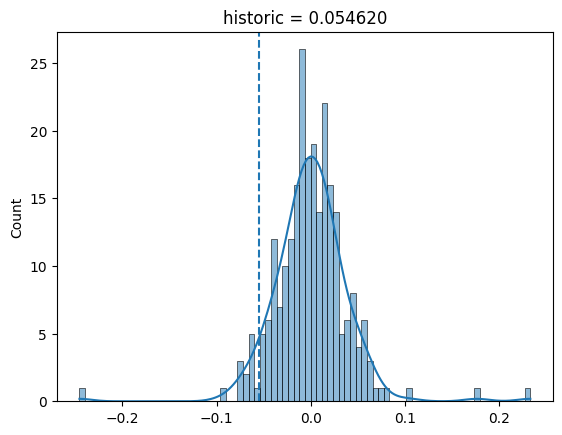

In [17]:
# plot
simu_norm, var_norm=var_normal_distribution(META_zero)
#print(simu_norm)
#print(var_norm)
plot_var(simu_norm,var_norm,'Norm')

simu_norm, var_norm=var_normal_weighted(META_zero)
plot_var(simu_norm,var_norm,'Norm_weighted')

simu_norm, var_norm=var_t_MLE(META_zero)
plot_var(simu_norm,var_norm,'T_MLE')

simu_norm, var_norm=var_ar1(META_zero)
plot_var(simu_norm,var_norm,'ar1')

simu_norm, var_norm=var_historic(META_zero)
plot_var(simu_norm,var_norm,'historic')

### Problem 3
Using Portfolio.csv and DailyPrices.csv.  Assume the expected return on all stocks is 0.
This file contains the stock holdings of 3 portfolios.  You own each of these portfolios.  Using an
exponentially weighted covariance with lambda = 0.94, calculate the VaR of each portfolio as
well as your total VaR (VaR of the total holdings).  Express VaR as a $.
Discuss your methods and your results.
Choose a different model for returns and calculate VaR again.  Why did you choose that model?
How did the model change affect the results?

In [264]:
# read data
portfolio = pd.read_csv("portfolio.csv")
prices = pd.read_csv("DailyPrices.csv")
print(portfolio)

   Portfolio Stock  Holding
0          A  AAPL       58
1          A  TSLA       10
2          A   JPM       64
3          A    HD       27
4          A   BAC      209
..       ...   ...      ...
94         C     F      397
95         C  LRCX       14
96         C    MO      197
97         C   LMT       27
98         C   TFC      149

[99 rows x 3 columns]


In [478]:
# split portfolio

A_portfolio =  portfolio[portfolio["Portfolio"] == "A"]
B_portfolio =  portfolio[portfolio["Portfolio"] == "B"]
C_portfolio =  portfolio[portfolio["Portfolio"] == "C"]

a=portfolio.drop('Portfolio',axis=1)
total_portfolio = a.groupby('Stock', as_index=False).sum('Holding')


In [444]:
# calculate price a/b/c

def cal_porfolio_price(portfolio_type,prices):
    stock_name = list(portfolio_type["Stock"])
    assets_prices = pd.concat([prices["Date"], prices[stock_name]], axis=1)
    current_price = np.dot(prices[portfolio_type["Stock"]].tail(1), portfolio_type["Holding"])
    holdings = portfolio_type["Holding"]

    return current_price,assets_prices,holdings
cal_porfolio_price(A_portfolio,prices)

(array([299950.05907389]),
                Date        AAPL        TSLA         JPM          HD  \
 0    2/14/2022 0:00  167.863144  291.920013  147.619888  342.932312   
 1    2/15/2022 0:00  171.749573  307.476654  149.778656  344.590576   
 2    2/16/2022 0:00  171.511032  307.796661  150.049713  341.498352   
 3    2/17/2022 0:00  167.863144  292.116669  146.593735  339.401123   
 4    2/18/2022 0:00  166.292648  285.660004  147.281052  338.357391   
 ..              ...         ...         ...         ...         ...   
 244   2/3/2023 0:00  154.264465  189.979996  141.089996  331.500000   
 245   2/6/2023 0:00  151.498688  194.759995  141.919998  329.269989   
 246   2/7/2023 0:00  154.414230  196.809998  143.649994  325.200012   
 247   2/8/2023 0:00  151.688400  201.289993  142.639999  320.790008   
 248   2/9/2023 0:00  150.639999  207.320007  140.419998  315.549988   
 
            BAC         XOM        AVGO         PEP         TMO  ...  \
 0    46.340988   76.808563  560.55

In [465]:
# all 
def Norm_price(portfolio_type,prices):
    stock_name = list(portfolio_type["Stock"])
    assets_prices = pd.concat([prices["Date"], prices[stock_name]], axis=1)
    current_price = np.dot(prices[portfolio_type["Stock"]].tail(1), portfolio_type["Holding"])

    val = portfolio_type["Holding"].values.reshape(-1,1) * prices[portfolio_type["Stock"]].tail(1).T.values
    hold = val/current_price
   

    return current_price,assets_prices,hold
Norm_price(total_portfolio,prices)

(array([864378.48041924]),
                Date        AAPL        ABBV         ABT         ACN  \
 0    2/14/2022 0:00  167.863144  137.756256  120.633438  321.260742   
 1    2/15/2022 0:00  171.749573  139.451721  121.812462  324.491760   
 2    2/16/2022 0:00  171.511032  140.521042  121.517708  328.737427   
 3    2/17/2022 0:00  167.863144  139.654022  118.471909  318.088837   
 4    2/18/2022 0:00  166.292648  138.748505  114.748161  316.384644   
 ..              ...         ...         ...         ...         ...   
 244   2/3/2023 0:00  154.264465  145.199997  111.790001  289.220001   
 245   2/6/2023 0:00  151.498688  145.020004  110.750000  284.480011   
 246   2/7/2023 0:00  154.414230  145.139999  111.989998  287.820007   
 247   2/8/2023 0:00  151.688400  144.610001  110.199997  284.709992   
 248   2/9/2023 0:00  150.639999  148.699997  108.070000  285.160004   
 
            ADBE         ADI         ADP        AMAT         AMD  ...  \
 0    474.010010  151.118790  198.

In [479]:
# Delta Normal VaR
def Delta_Normal_VaR(portfolio_type,prices,lambda_=0.94,style='All'):
    if style == 'All':
        current_price, assets_prices, hold = Norm_price(portfolio_type,prices)
    else:
        current_price, assets_prices, hold = cal_porfolio_price(portfolio_type,prices)
    ret = return_calculate(assets_prices).drop('Date', axis=1)
    cov = exp_weighted_cov(ret,lambda_)
    sigm = np.sqrt(np.transpose(hold) @ cov @ hold)
    var = -current_price * norm.ppf(0.05) * sigm

    return current_price[0], var[0][0]

Delta_Normal_VaR(total_portfolio,prices)

(864378.48041924, 13577.077108381169)

In [447]:
def multivariate_normal_simulation(covariance_matrix, n_samples, explained_variance=1.0):

        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
        mask = eigenvalues > np.finfo(np.float32).eps
        eigenvalues = eigenvalues[mask][::-1]
        eigenvectors = eigenvectors[:, mask][:, ::-1]
        
        if explained_variance == 1.0:
            explained_variance = 1.0
        elif explained_variance <= 0.0:
            raise ValueError("explained_variance must be a positive number")
        else:
            explained_variance = min(1.0, explained_variance)
        
        cum_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)
        n_components = np.searchsorted(cum_var, explained_variance, side='right')
        z = np.random.normal(size=(n_components, n_samples))
        B = eigenvectors[:, :n_components] * np.sqrt(eigenvectors[:n_components])
        x = np.dot(B, z).T

        return x



In [481]:
# Normal Monte Carlo vaR

def cal_monte_var(portfolio_type,prices, n=10000,lambda_=0.94,alpha=5):
    
    current_price, assets_prices, hold = cal_porfolio_price(portfolio_type,prices)


    re_n = return_calculate(assets_prices).drop('Date', axis=1)

    re_no = re_n - re_n.mean()

    cov = exp_weighted_cov(re_no,lambda_)
  
    np.random.seed(0)
    return_simu = np.add(multivariate_normal_simulation(cov,n),re_n.mean().values)
    assets_prices = assets_prices.drop('Date',axis=1)
    sp=np.dot(return_simu*assets_prices.tail(1).values.reshape(assets_prices.shape[1],),hold)
    var = -np.percentile(sp, alpha)
    return current_price[0], var,sp

cal_monte_var(total_portfolio,prices)

    

(864378.48041924,
 13308.901605555398,
 array([12646.25789508,  2350.67564745, 10815.96882451, ...,
         7421.62602005, -6667.69940715,  4823.7237544 ]))

In [483]:
# historical var
def cal_historical(portfolio_type, prices,n=10000,alpha=5):
    
    current_price, assets_prices, hold = cal_porfolio_price(portfolio_type,prices)
    ret = return_calculate(assets_prices).drop('Date', axis=1)
    
    assets_prices = assets_prices.drop('Date',axis=1)
    simu = ret.sample(n,replace=True)
    his_pri = np.dot(simu * assets_prices.tail(1).values.reshape(assets_prices.shape[1]), hold)
    

    var_historical = -np.percentile(his_pri, alpha)

    return current_price[0], var_historical, his_pri
cal_historical(total_portfolio,prices)
    

(864378.48041924,
 21103.398010768073,
 array([  -213.17709628,   -575.99755001,  19723.60020775, ...,
        -12390.81739857,  -6018.27916012,  -2022.96502053]))

All porfolio
Current value: 864378.4804
Normal VAR: 13577.0771


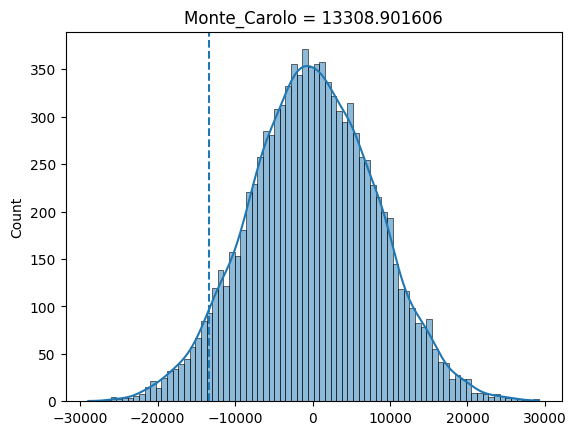

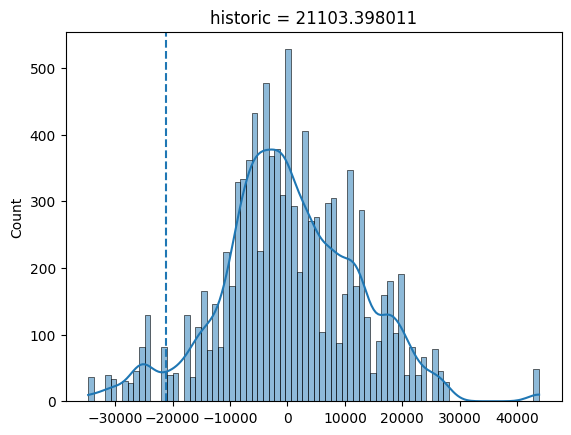

In [491]:
# plot all porfolio
print("All porfolio")
simu_norm, var_norm=Delta_Normal_VaR(total_portfolio,prices)
print("Current value: {:.4f}".format(simu_norm))
print("Normal VAR: {:.4f}".format(var_norm))
simu_norm, var_norm,monte_price=cal_monte_var(total_portfolio,prices)
plot_var(monte_price,var_norm,'Monte_Carolo')
simu_norm, var_norm,his_price=cal_historical(total_portfolio,prices)
plot_var(his_price,var_norm,'historic')

A porfolio
Current value: 299950.0591
Normal VAR: 5670.2035


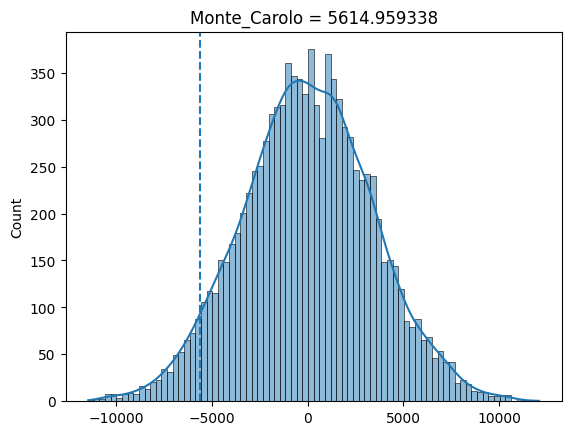

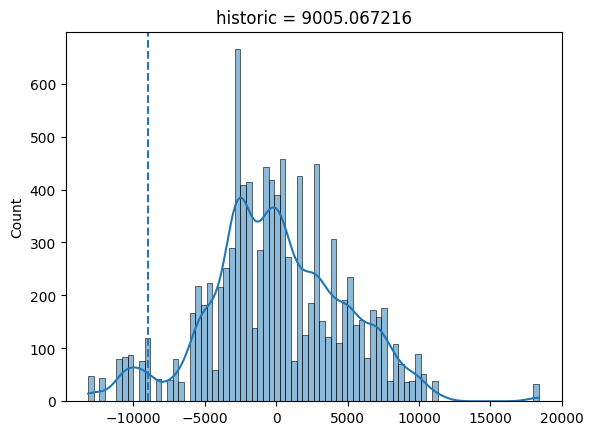

In [492]:
# plot A porfolio
print("A porfolio")
simu_norm, var_norm=Delta_Normal_VaR(A_portfolio,prices)
print("Current value: {:.4f}".format(simu_norm))
print("Normal VAR: {:.4f}".format(var_norm))
simu_norm, var_norm,monte_price=cal_monte_var(A_portfolio,prices)
plot_var(monte_price,var_norm,'Monte_Carolo')
simu_norm, var_norm,his_price=cal_historical(A_portfolio,prices)
plot_var(his_price,var_norm,'historic')

B porfolio
Current value: 294385.5908
Normal VAR: 4494.5990


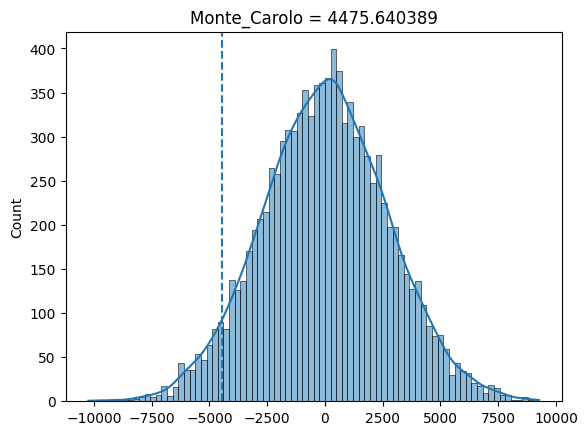

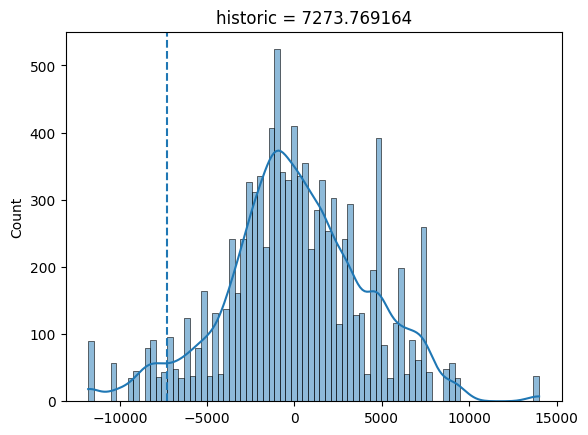

In [493]:
# plot B porfolio
print("B porfolio")
simu_norm, var_norm=Delta_Normal_VaR(B_portfolio,prices)
print("Current value: {:.4f}".format(simu_norm))
print("Normal VAR: {:.4f}".format(var_norm))
simu_norm, var_norm,monte_price=cal_monte_var(B_portfolio,prices)
plot_var(monte_price,var_norm,'Monte_Carolo')
simu_norm, var_norm,his_price=cal_historical(B_portfolio,prices)
plot_var(his_price,var_norm,'historic')

C porfolio
Current value: 270042.8305
Normal VAR: 3786.5895


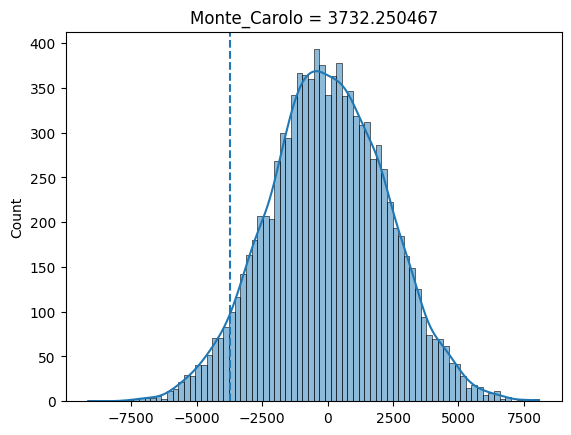

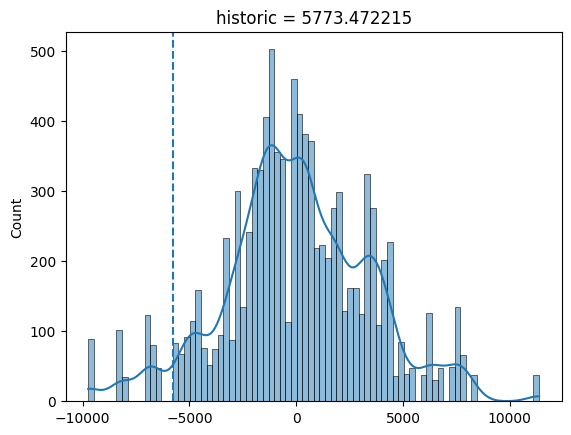

In [494]:
# plot C porfolio
print("C porfolio")
simu_norm, var_norm=Delta_Normal_VaR(C_portfolio,prices)
print("Current value: {:.4f}".format(simu_norm))
print("Normal VAR: {:.4f}".format(var_norm))
simu_norm, var_norm,monte_price=cal_monte_var(C_portfolio,prices)
plot_var(monte_price,var_norm,'Monte_Carolo')
simu_norm, var_norm,his_price=cal_historical(C_portfolio,prices)
plot_var(his_price,var_norm,'historic')